In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import yfinance as yf
import keras 
import os
import tensorflow
import datetime 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras import optimizers
from keras.models import Model
from keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import random
import scipy.stats as st

In [2]:
def DataPrep(ticker,daysago,split_pct):
    #simple data prep
    df = yf.Ticker(ticker.upper()).history(period='max')
    df = df[['Close']]
    # df.plot(figsize=(10,10))
    for i in range(daysago, -1,-1):
        df[f'{i} daysago'] = df['Close'].shift(i)
        df = df.copy()
    df = df.dropna()
    df = df.drop(columns=['Close'])
    df
    #ok so if i have tmrs price be the mean of the prob distro,
    # using stddev i can map a psuedo confidence interval type shit

    #if i use a normal distro, unlike the digits recognition ml, 
    #whos output is discrete(a vector of probabilities),
    #my output would have to resemble a continuous function, 
    #to simulate the normal distro

    df['stddev'] = np.std(df,axis=1)
    df['mean'] = np.mean(df,axis=1)
    df['z'] = (df['0 daysago'].shift(-1) - df['mean'])/df['stddev']
    df = df.dropna()
    Y = []
    for yah in df['z']:
        if yah < -3:
            Y.append([1,0,0,0,0,0,0,0])
        elif yah >= -3 and yah <-2:
            Y.append([0,1,0,0,0,0,0,0])
        elif yah >= -2 and yah <-1:
            Y.append([0,0,1,0,0,0,0,0])
        elif yah >= -1 and yah <0:
            Y.append([0,0,0,1,0,0,0,0])
        elif yah >= 0 and yah <1:
            Y.append([0,0,0,0,1,0,0,0])    
        elif yah >= 1 and yah <2:
            Y.append([0,0,0,0,0,1,0,0])
        elif yah >= 2 and yah <3:
            Y.append([0,0,0,0,0,0,1,0])
        elif yah >= 3:
            Y.append([0,0,0,0,0,0,0,1])
    Y = np.array(Y)
    # df = df.drop(columns=['stddev'])
    # df = df.drop(columns=['mean'])
    df = df.drop(columns=['z'])

    sc = MinMaxScaler(feature_range=(0,1))
    scaled = sc.fit_transform(df)
    X = scaled[:,:daysago+1+2]
    split = int(len(X)*split_pct)
    X_train, X_test, Y_train, Y_test = X[:split], X[split:], Y[:split], Y[split:]
    X_train, X_test, Y_train, Y_test = X_train.reshape((-1,daysago+1+2,1)), X_test.reshape((-1,daysago+2+1,1)), Y_train.reshape((-1,8,1)), Y_test.reshape((-1,8,1))
    return X_train, X_test, Y_train, Y_test


In [3]:
# Output should be a vector, 13 Xs maybe, like [-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]
# being the stddevs from tmrs price, and the values would be the %prob
# [0.ugly, 0.decent, 0.highest, 0.decent, 0.ugly] to simplify
# function to convert might look smth like this:
DataPrep('aapl',10,0.8)
# output = [0.01,0.1,0.78,0.1,0.01]

# #for list
# max_index = np.argmax(output)
# z = st.norm.ppf(max(output))



# df = yf.Ticker('AAPL').history(start='2010-01-01',end='2010-01-20')
# df = np.array(df['Close'])
# sigma = np.std(df)
# mu = np.mean(df)
# sigma, mu,df

# z = (df[-1]-mu)/sigma
# st.norm.cdf(z)

# np.floor(z), np.ceil(z)


#wait a minute price data isnt normally distributed, its lognormal?
#i think i need to log transform the data to make it normally distributed
#price %return is normally distributed(i think?), so i can use that to predict price, but ml is shit with it so idk


(array([[[0.00027609],
         [0.00024741],
         [0.00021555],
         ...,
         [0.00036688],
         [0.00126096],
         [0.00026978]],
 
        [[0.00025276],
         [0.00021696],
         [0.000225  ],
         ...,
         [0.00035404],
         [0.00137639],
         [0.00027892]],
 
        [[0.00022165],
         [0.00022647],
         [0.00023635],
         ...,
         [0.00033937],
         [0.00138328],
         [0.00028834]],
 
        ...,
 
        [[0.11286973],
         [0.1092022 ],
         [0.11109255],
         ...,
         [0.10935922],
         [0.03029302],
         [0.11003677]],
 
        [[0.1115636 ],
         [0.11181909],
         [0.11057652],
         ...,
         [0.11103436],
         [0.03956856],
         [0.11049406]],
 
        [[0.11423707],
         [0.11129968],
         [0.11076507],
         ...,
         [0.11448097],
         [0.0582881 ],
         [0.11142183]]]),
 array([[[0.11370644],
         [0.11148947],
         

In [4]:

X_train = []
X_test = []
Y_train = []
Y_test = []
X_train,X_test,Y_train,Y_test = np.array(X_train), np.array(X_test), np.array(Y_train), np.array(Y_test)
X_train,X_test,Y_train,Y_test = X_train.reshape(-1,103,1),X_test.reshape(-1,103,1),Y_train.reshape(-1,8,1),Y_test.reshape(-1,8,1)


sp500list = pd.read_csv("4th attempt total/SP500.csv")
ListOfTickers = []
for i in sp500list['Symbol']:
    ListOfTickers.append(i)

ListOfTickers.remove('BRK.B')
ListOfTickers.remove('BF.B')
ListOfTickers.remove('GEV')
ListOfTickers.remove('SOLV')
ListOfTickers.remove('HUBB')

for ticker in ListOfTickers:
    print(ticker)
    dataprep = DataPrep(ticker,100,0.99)
    X_train = np.append(X_train,dataprep[0],axis=0)
    X_test = np.append(X_test,dataprep[1],axis=0)
    Y_train = np.append(Y_train,dataprep[2],axis=0)
    Y_test = np.append(Y_test,dataprep[3],axis=0)

X_train.shape,X_test.shape,Y_train.shape,Y_test.shape


MMM
AOS
ABT
ABBV
ACN
ADBE
AMD
AES
AFL
A
APD
ABNB
AKAM
ALB
ARE
ALGN
ALLE
LNT
ALL
GOOGL
GOOG
MO
AMZN
AMCR
AEE
AAL
AEP
AXP
AIG
AMT
AWK
AMP
AME
AMGN
APH
ADI
ANSS
AON
APA
AAPL
AMAT
APTV
ACGL
ADM
ANET
AJG
AIZ
T
ATO
ADSK
ADP
AZO
AVB
AVY
AXON
BKR
BALL
BAC
BK
BBWI
BAX
BDX
BBY
BIO
TECH
BIIB
BLK
BX
BA
BKNG
BWA
BXP
BSX
BMY
AVGO
BR
BRO
BLDR
BG
CDNS
CZR
CPT
CPB
COF
CAH
KMX
CCL
CARR
CTLT
CAT
CBOE
CBRE
CDW
CE
COR
CNC
CNP
CF
CHRW
CRL
SCHW
CHTR
CVX
CMG
CB
CHD
CI
CINF
CTAS
CSCO
C
CFG
CLX
CME
CMS
KO
CTSH
CL
CMCSA
CMA
CAG
COP
ED
STZ
CEG
COO
CPRT
GLW
CPAY
CTVA
CSGP
COST
CTRA
CCI
CSX
CMI
CVS
DHR
DRI
DVA
DAY
DECK
DE
DAL
DVN
DXCM
FANG
DLR
DFS
DG
DLTR
D
DPZ
DOV
DOW
DHI
DTE
DUK
DD
EMN
ETN
EBAY
ECL
EIX
EW
EA
ELV
LLY
EMR
ENPH
ETR
EOG
EPAM
EQT
EFX
EQIX
EQR
ESS
EL
ETSY
EG
EVRG
ES
EXC
EXPE
EXPD
EXR
XOM
FFIV
FDS
FICO
FAST
FRT
FDX
FIS
FITB
FSLR
FE
FI
FMC
F
FTNT
FTV
FOXA
FOX
BEN
FCX
GRMN
IT
GE
GEHC
GEN
GNRC
GD
GIS
GM
GPC
GILD
GPN
GL
GS
HAL
HIG
HAS
HCA
DOC
HSIC
HSY
HES
HPE
HLT
HOLX
HD
HON
HRL
HST
HWM
HPQ
HUM
HBAN
HII
IBM

((4096596, 103, 1), (41619, 103, 1), (4096596, 8, 1), (41619, 8, 1))

In [5]:
model3 = Sequential()
model3.add(InputLayer((103, 1)))
model3.add(LSTM(75))
model3.add(Dense(25, 'linear'))
model3.add(Dense(8, 'softmax'))

cp1 = ModelCheckpoint('model/6th.keras', save_best_only=False)
model3.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001), metrics=['acc'])
model3.fit(X_train, Y_train, epochs=2, batch_size=128, callbacks=[cp1])


Epoch 1/2
32005/32005 ━━━━━━━━━━━━━━━━━━━━ 2270s 71ms/step - acc: 0.0023 - loss: 1.2203
Epoch 2/2
32005/32005 ━━━━━━━━━━━━━━━━━━━━ 2364s 74ms/step - acc: 0.0048 - loss: 0.8630


1301/1301 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step


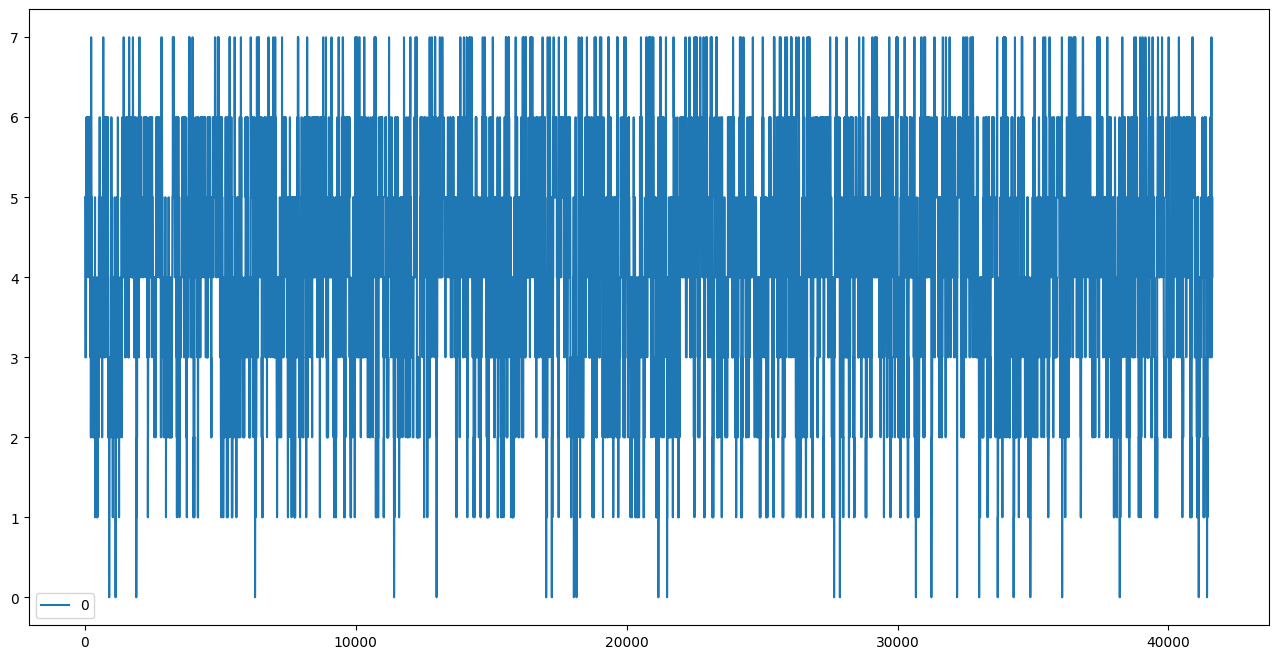

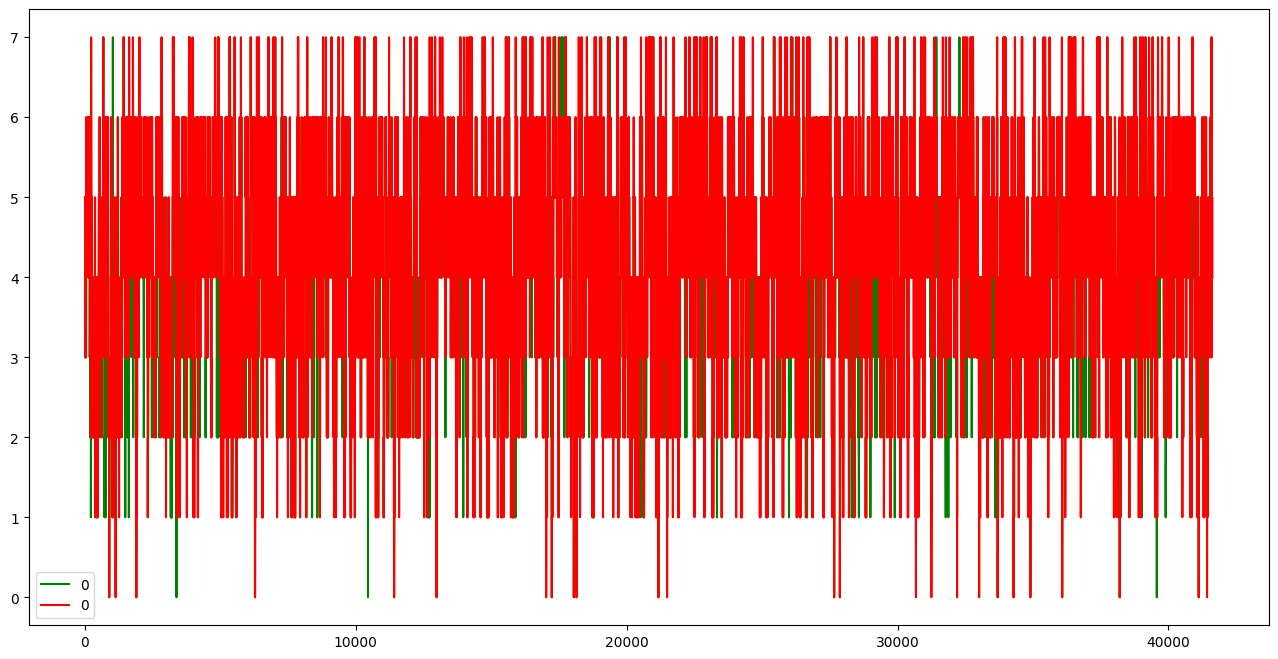

In [8]:
model3 = load_model('model/6th.keras')
y_pred = model3.predict(X_test)
y_pred_acc = np.argmax(y_pred,axis=1)
Y_test_acc = np.argmax(Y_test,axis=1)
Y_test_acc.shape,y_pred_acc.shape
# print(y_pred.shape)
# avg_error = (np.sum(np.sqrt((Y_test - y_pred)**2)))/len(Y_test)*100
# print(avg_error)
# avg_error = (np.sum(y_pred - Y_test))/len(Y_test)*100
# print(avg_error)

sp500_y_pred,sp500_Y_test = pd.DataFrame(y_pred_acc),pd.DataFrame(Y_test_acc)
sp500_Y_test.plot(figsize=(16,8))
for i in range(0,sp500_y_pred.shape[1]): 
    oneday= pd.concat([sp500_y_pred[i],sp500_Y_test[i]],axis=1)
    oneday.plot(figsize=(16,8),color = ('green','red'))

    

In [9]:
fawk = y_pred_acc == Y_test_acc.reshape(-1)
fawk = fawk.astype(int)
fawk = np.sum(fawk)/len(fawk)*100
fawk

64.57627525889617